In [1]:
# If using docker make sure that git is installed
!pip install git+https://github.com/JihongJu/keras-fcn.git -q
!pip install keras -q

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import pathlib, glob, re
import os
from PIL import Image
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Conv2D, Add, Conv2DTranspose, Activation
%pylab inline
tf.enable_eager_execution()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

Populating the interactive namespace from numpy and matplotlib


In [3]:
ds_root = f'{os.path.expanduser("~")}/data/datasets/pascalvoc/VOCdevkit/VOC2012/'
images_path = ds_root + 'JPEGImages/'
train_set = ds_root + 'ImageSets/Segmentation/train.txt'
val_set = ds_root + 'ImageSets/Segmentation/val.txt'
labels_path =  ds_root + 'SegmentationClass/'

In [4]:
with open(train_set) as ts:
    train_image_names = ts.read().split()
with open(val_set) as ts:
    val_image_names = ts.read().split()

In [5]:
def load_and_preprocess_png(path):
    image = Image.open(path)
    image = np.array(image)
    # Do we want to classify background?
    image[image == 255.] = 0.
    image = tf.one_hot(image, 21)
    # Method 1 = nearest neighbour
    image = tf.image.resize_images(image, [256, 256], method=1)
    return image

def load_and_preprocess_jpg(path):
    path = tf.convert_to_tensor(path, dtype=tf.string)
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [256, 256])
    image /= tf.constant(255.0)
    return image

def load_and_preprocess(path, label_path):
    return load_and_preprocess_jpg(path), load_and_preprocess_png(label_path)

def dataset_generator():
    i = 0
    while True:
        i = (i+1) % len(train_paths)
        yield load_and_preprocess(train_paths[i], train_label_paths[i])        

In [6]:
def load_dataset(paths, labels):
    ds = tf.data.Dataset.from_generator(dataset_generator, output_types=(
        tf.float32, tf.float32))
    ds = ds.shuffle(buffer_size=32)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [7]:
train_paths = [images_path + name + '.jpg' for name in train_image_names]
train_label_paths = [labels_path + name + '.png' for name in train_image_names]
val_paths = [images_path + name + '.jpg' for name in val_image_names]
val_label_paths = [labels_path + name + '.png' for name in val_image_names]

In [8]:
BATCH_SIZE = 8
train_ds = load_dataset(train_paths, train_label_paths)
val_ds = load_dataset(val_paths, val_label_paths)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [9]:
data, target = iter(train_ds).next()

Instructions for updating:
Colocations handled automatically by placer.


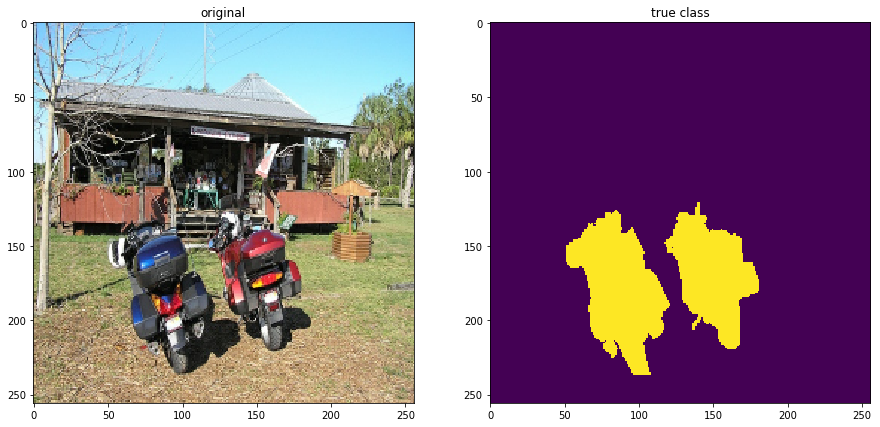

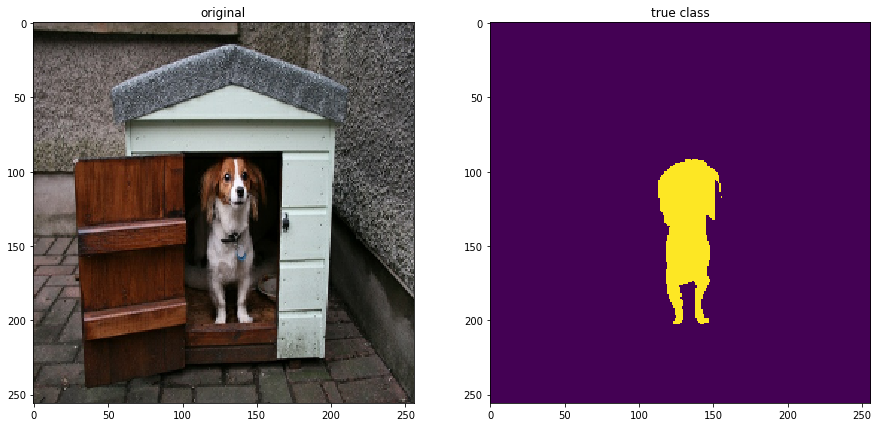

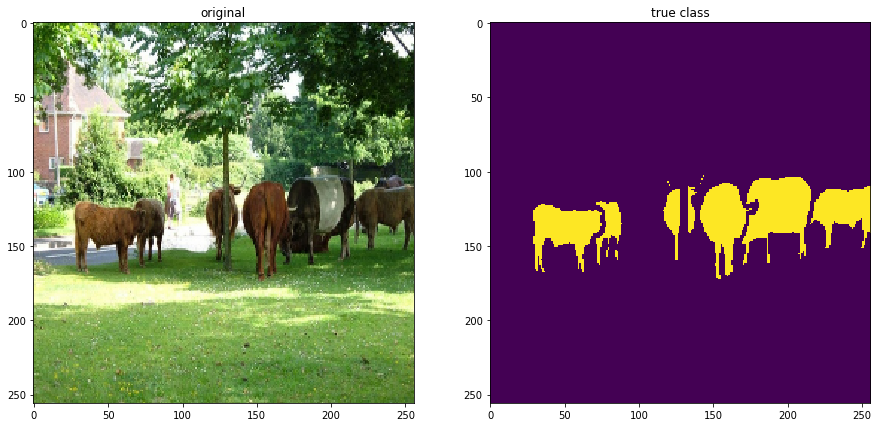

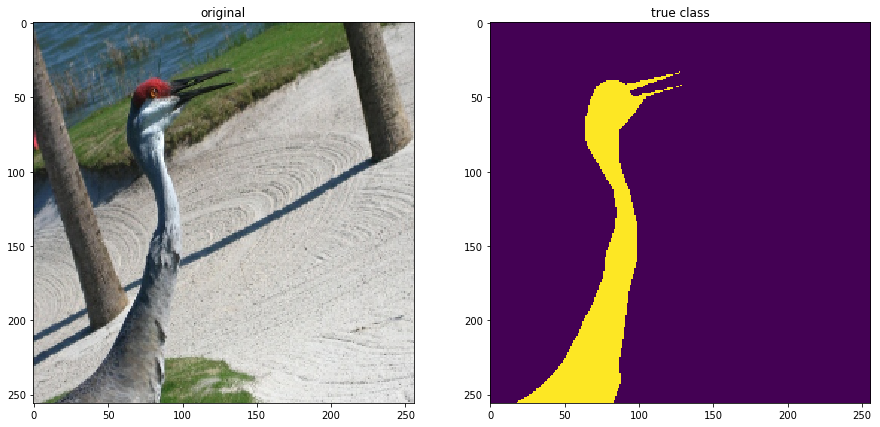

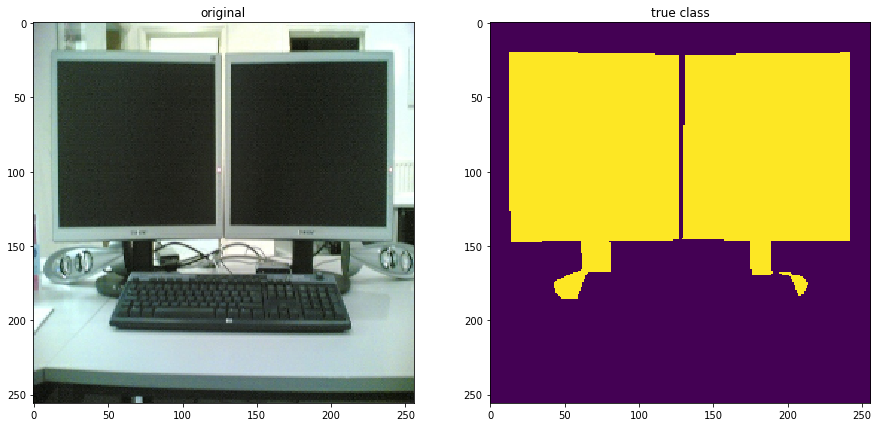

In [10]:
for i in range(5):
    fig = plt.figure(figsize=(15,30)) 
    ax = fig.add_subplot(1,2,1)
    ax.imshow(data[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(np.argmax(target[i], axis=2))
    ax.set_title("true class")
    
    plt.show()

In [23]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [24]:
inputs = layers.Input(shape=(256, 256, 3))
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256


outputs = layers.Conv2D(21, (1, 1), activation=None)(decoder0)
# outputs = (layers.Activation('softmax'))(outputs)

In [26]:
# n = 4096
# classes = 21

# conv6 = (Conv2D(n, (8, 8), activation='relu', padding='same', name="conv6"))(block5_pool.output)
# conv7 = (Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7"))(conv6)

# ## 4 times upsamping for pool4 layer
# conv7_4 = Conv2DTranspose(classes, kernel_size=(4,4), strides=(4,4), use_bias=False)(conv7)
# ## (None, 224, 224, 10)
# ## 2 times upsampling for pool411
# pool411 = (Conv2D(classes, (1, 1), activation='relu', padding='same', name="pool4_11"))(block4_pool.output)
# pool411_2 = (Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2), use_bias=False))(pool411)

# pool311 = (Conv2D(classes, (1, 1), activation='relu', padding='same', name="pool3_11"))(block3_pool.output)

# out = Add(name="add")([pool411_2, pool311, conv7_4])
# out = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(out)
# out = (Activation('softmax'))(out)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tf.nn.softmax_cross_entropy_with_logits_v2,
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_27 (Batc (None, 256, 256, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 256, 256, 32) 0           batch_normalization_v1_27[0][0]  
__________________________________________________________________________________________________
conv2d_24 

In [28]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    validation_steps=len(val_paths)//BATCH_SIZE,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    epochs=10
)

Epoch 1/10
183/183 [==============================] - 166s 906ms/step - loss: 12.7082 - acc: 0.7030 - val_loss: 36.0825 - val_acc: 0.1715
Epoch 2/10
183/183 [==============================] - 139s 758ms/step - loss: 9.4865 - acc: 0.7485 - val_loss: 10.6968 - val_acc: 0.7163
Epoch 3/10
183/183 [==============================] - 143s 782ms/step - loss: 9.2605 - acc: 0.7487 - val_loss: 9.7310 - val_acc: 0.7499
Epoch 4/10
183/183 [==============================] - 138s 754ms/step - loss: 9.0845 - acc: 0.7506 - val_loss: 9.3977 - val_acc: 0.7502
Epoch 5/10
183/183 [==============================] - 138s 753ms/step - loss: 9.0133 - acc: 0.7499 - val_loss: 8.9559 - val_acc: 0.7504
Epoch 6/10
183/183 [==============================] - 131s 718ms/step - loss: 8.9100 - acc: 0.7491 - val_loss: 8.9648 - val_acc: 0.7484
Epoch 7/10
183/183 [==============================] - 130s 713ms/step - loss: 8.7719 - acc: 0.7515 - val_loss: 10.5141 - val_acc: 0.7337
Epoch 8/10
183/183 [========================

In [29]:
hist2 = model.fit(
    train_ds,
    validation_data=val_ds,
    validation_steps=len(val_paths)//BATCH_SIZE,
    steps_per_epoch=len(train_paths)//BATCH_SIZE,
    epochs=10
)

Epoch 1/10
183/183 [==============================] - 142s 774ms/step - loss: 8.5336 - acc: 0.7516 - val_loss: 8.5701 - val_acc: 0.7522
Epoch 2/10
183/183 [==============================] - 135s 739ms/step - loss: 8.3823 - acc: 0.7529 - val_loss: 8.8703 - val_acc: 0.7408
Epoch 3/10
183/183 [==============================] - 139s 760ms/step - loss: 8.2446 - acc: 0.7542 - val_loss: 8.1311 - val_acc: 0.7540
Epoch 4/10
183/183 [==============================] - 134s 731ms/step - loss: 8.2027 - acc: 0.7538 - val_loss: 8.4894 - val_acc: 0.7435
Epoch 5/10
183/183 [==============================] - 138s 756ms/step - loss: 8.0478 - acc: 0.7557 - val_loss: 9.4137 - val_acc: 0.7288
Epoch 6/10
183/183 [==============================] - 131s 717ms/step - loss: 7.9956 - acc: 0.7575 - val_loss: 8.2968 - val_acc: 0.7540
Epoch 7/10
183/183 [==============================] - 131s 714ms/step - loss: 7.8483 - acc: 0.7579 - val_loss: 7.6440 - val_acc: 0.7626
Epoch 8/10
183/183 [============================

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


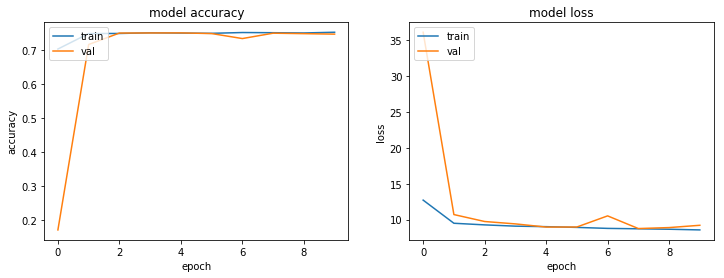

In [30]:
def field(x):
    return hist.history[x]
#     return hist.history[x] +  hist2.history[x]
fig, ax = plt.subplots(1, 2)
ax[0].plot(field('acc'))
ax[0].plot(field('val_acc'))
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
ax[1].plot(field('loss'))
ax[1].plot(field('val_loss'))
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
fig.set_size_inches(12,4)
fig.show()

In [32]:
model.save('unet_20epochs')

RuntimeError: Unable to create link (name already exists)

In [33]:
# mdl = tf.keras.models.load_model('unet_20epochs')
mdl = model

In [34]:
data, target = iter(val_ds).next()
predictions = mdl.predict(np.array(data))

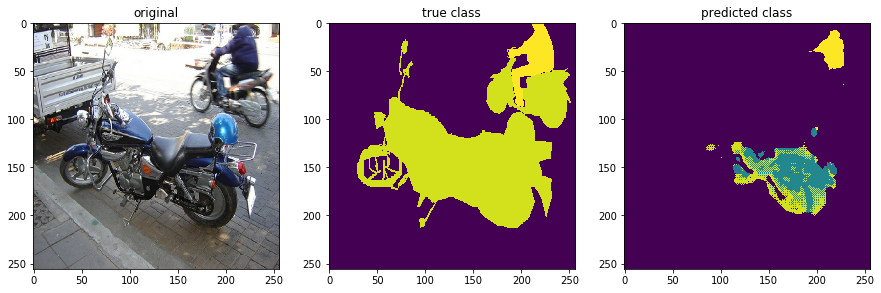

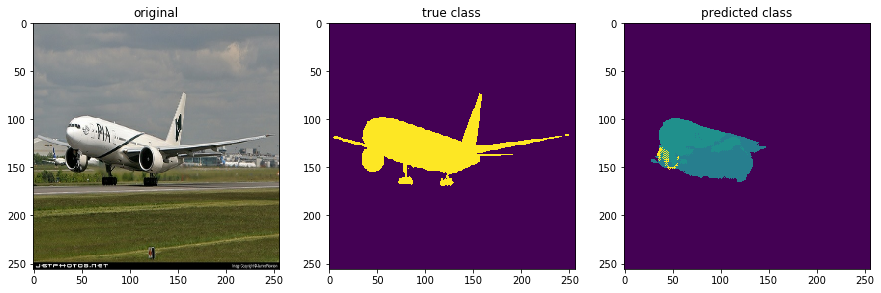

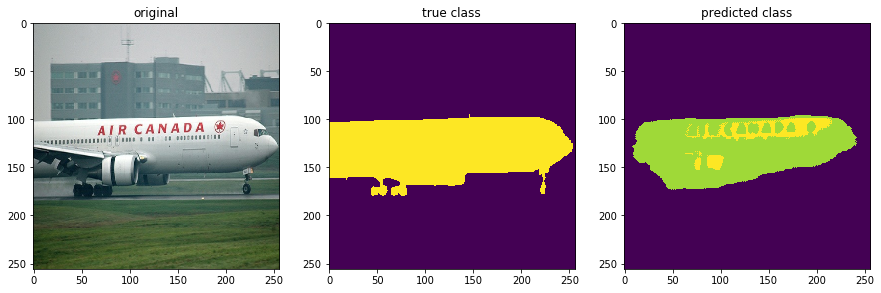

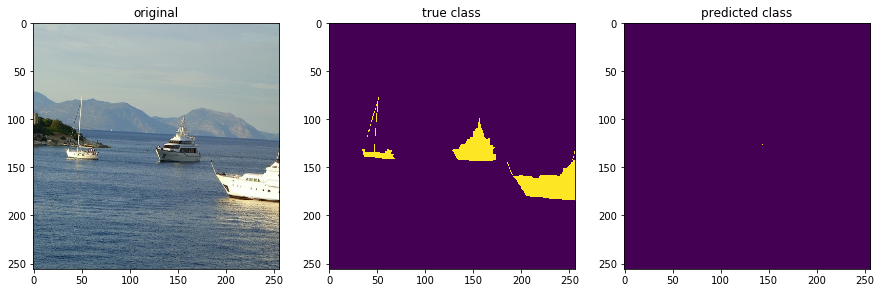

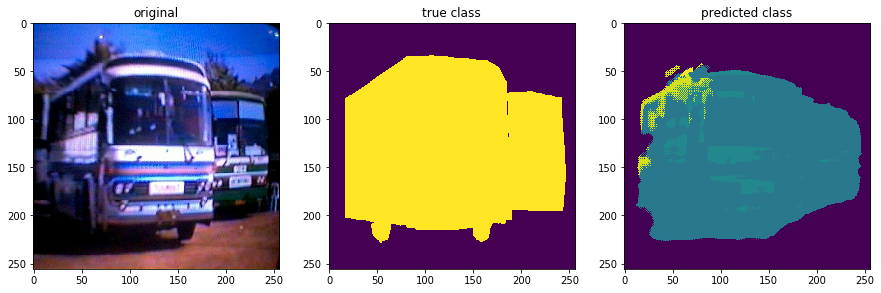

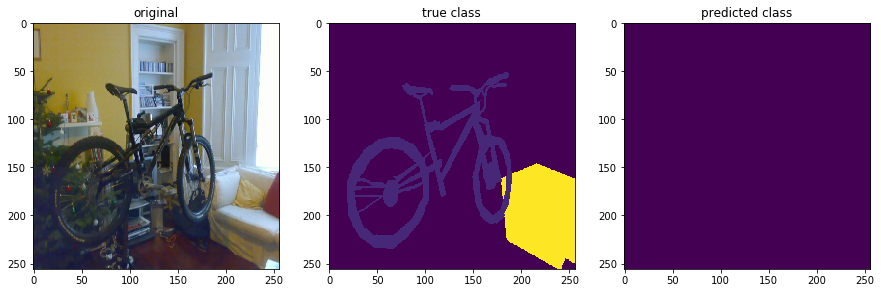

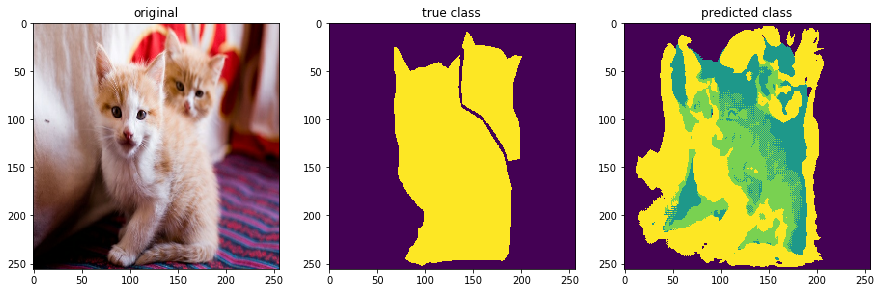

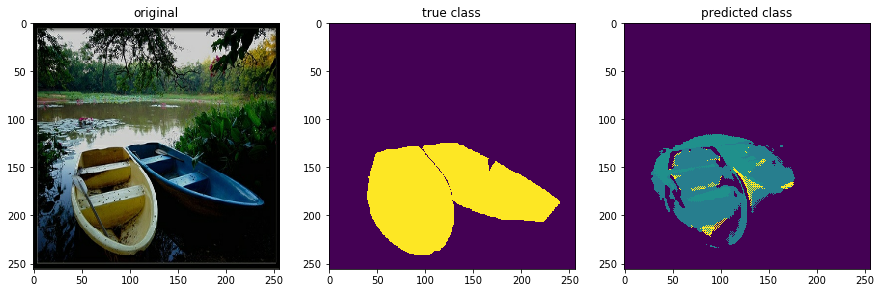

In [35]:
for i in range(8):
    fig = plt.figure(figsize=(15,30)) 
    ax = fig.add_subplot(1,3,1)
    ax.imshow(data[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(np.argmax(target[i], axis=2))
    ax.set_title("true class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(np.argmax(predictions[i], axis=2))
    ax.set_title("predicted class")
    plt.show()